# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from tqdm import tqdm
import scipy.io

# Load images

Here I have appended all the image frames to the imgs after zero padding. All the images are zero padded by 3 pixels on all 4 sides.

In [2]:
content_dict = scipy.io.loadmat('stack.mat')
pad_length = 3
imgs = []
for key in content_dict.keys():
    if key[:5]=='frame':
        img1 = content_dict[key]
        imgs.append(np.pad(img1, ((pad_length, pad_length), (pad_length, pad_length))))


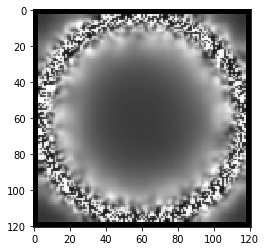

In [5]:
# Showing a sample image with the zero padding
plt.imshow(imgs[0], cmap = 'gray')

# Depth Estimation using SFF

## Focus operator

In [7]:
# Define the Modified Laplacian function. Here the input is just a 3x3 part of an image 
# while its output is obtained after applying the modified laplacian function on it.
def ML(imgij):
    # Define fxx and fyy
    fxx = np.array([[0,0,0],[-1,2,-1],[0,0,0]])
    fyy = np.array([[0,-1,0],[0,2,0],[0,-1,0]])
    return abs(np.sum(fxx*imgij)) + abs(np.sum(fyy*imgij))
    
# Define the Sum Modified Laplacian function. It takes the coordinate of an image and "q"
# as input and outputs the sum of all values when modified Laplacian function is applied 
# on each element of the kernel.  
def SML(img, x, y, q):
    ML_sum = 0
    for i in range(x-q, x+q+1):
        for j in range(y-q, y+q+1):
            imgij = img[i-1:i+2, j-1:j+2]
            ML_sum+=ML(imgij)
    return ML_sum

## Gaussian interpolation:
Given all the function values, return the output after gaussian interpolation to find 
the depth at which the Focus measure is the highest.

In [ ]:
def gaussian_interpolation(Fm, Fm1, Fm11, dm, delta_d):
    dm1 = dm-delta_d
    dm11 = dm+delta_d
    numer = (np.log(Fm)-np.log(Fm1))*(dm11**2-dm**2) - (np.log(Fm)-np.log(Fm11))*(dm1**2-dm**2)
    denom = 2*delta_d*(2*np.log(Fm) - np.log(Fm11) - np.log(Fm1))
    return numer/denom

## Shape from focus
Here the first frame is assumed to be at zero depth and each subsequent frame
is captured delta_d away from the previous frame.

In [8]:
# SFF applied for a specific value of "q"
def SFF(imgs, q, pad_l = pad_length, delta_d = 50.5):
    (l,w) = imgs[0].shape
    depths = np.zeros((l-2*pad_l, w-2*pad_l))
    focussed_img = np.zeros((l-2*pad_l, w-2*pad_l))
    # For each pixel, loop through all frames to find the frame at which the focus measure is the highest. 
    # The depth can be calculated after applying gaussian interpolation
    for x in tqdm(range(pad_l, l-pad_l)):
        for y in range(pad_l, l-pad_l):
            Fmax = -1e9
            dm = None
            for index in range(len(imgs)):
                Fi = SML(imgs[index], x, y, q=q)
                if Fi>Fmax:
                    Fmax = Fi
                    dm = index
            dbar = 0
            # If the highest value of SML is in the first or last frame, we cannot apply gaussian interpolation. 
            # We simply return the depth for that frame as shown below
            if dm==0 or dm==len(imgs)-1:
                dbar = dm*delta_d
            else:
                Fmax1 = SML(imgs[dm-1], x, y, q=q)
                Fmax11 = SML(imgs[dm+1], x, y, q=q)
                dbar = gaussian_interpolation(Fmax, Fmax1, Fmax11, dm*delta_d, delta_d)
            # Update the focussed image and depth map for each pixel
            focussed_img[x-pad_l, y-pad_l] = imgs[dm][x,y]
            depths[x-pad_l, y-pad_l] = dbar
    # Return depth map and focussed image
    return depths, focussed_img    




Compute the focussed image and depth map for q=0, q=1 and q=2

In [9]:
depth_maps, focussed_images = [], []
q_list = [0,1,2]
for q_val in q_list:
    depth_map, focussed_img = SFF(imgs, q=q_val)
    depth_maps.append(depth_map)
    focussed_images.append(focussed_img)

100%|██████████| 115/115 [17:47<00:00,  9.28s/it]


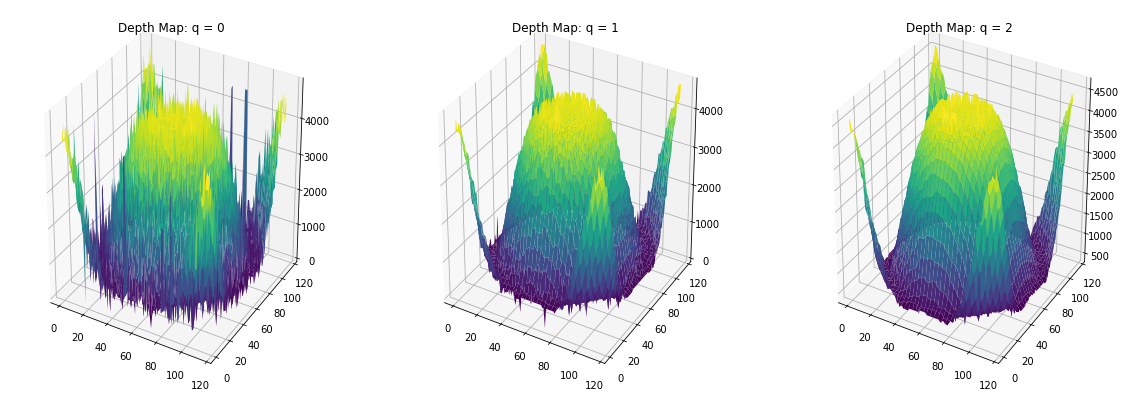

In [20]:
# Plot the depth maps in 3D
from mpl_toolkits.mplot3d import Axes3D

(l, w) = imgs[0].shape
lm, wm = np.meshgrid(np.arange(l-2*pad_length)+1, np.arange(w-2*pad_length)+1)
fig = plt.figure(figsize=(20,7))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plt.title("Depth Map: q = %d"%(q_list[i]))  
    ax.plot_surface(lm, wm, depth_maps[i], cmap = 'viridis')
plt.show()

Comparing all three depth maps, we see that as q increases, the depth map is a lot smoother.<br>
Let us also look at all the 3 focussed images.

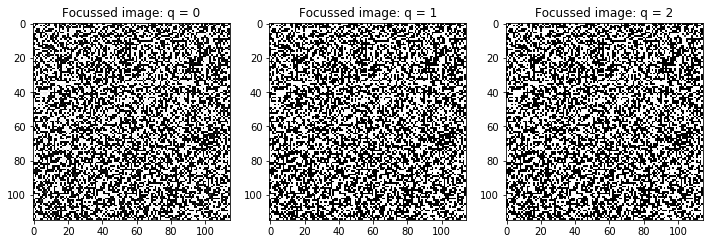

In [10]:
# Plot all 3 focussed images
f, axs = plt.subplots(1, 3, figsize = (12,9))
for i in range(3):
    axs[i].set_title("Focussed image: q = %d"%(q_list[i]))
    axs[i].imshow(focussed_images[i], cmap = 'gray')
plt.show()

There is hardly any perceptible difference in the focussed images corresponding to the three values of q. <br>
Since there is rich texture in the image, we can see all the focussed image clearly. This might not be the case for images with less texture.